# Import Modules

In [1]:
import importlib
import os
import sys

import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns

os.chdir("../")
sys.path.insert(0, os.getcwd())

In [2]:
from morai.dashboard.utils import dashboard_helper as dh
from morai.experience import charters, credibility, eda, tables
from morai.forecast import metrics, models, preprocessors
from morai.utils import custom_logger, helpers

In [3]:
# update log level if wanting more logging
custom_logger.set_log_level("INFO")

In [4]:
pd.options.display.float_format = "{:,.2f}".format

# Load Data

In [5]:
pl_parquet_path = r"files/dataset/mortality_grouped.parquet"

In [6]:
# reading in the dataset
# `enable_string_cache` helps with categorical type values
pl.enable_string_cache()
lzdf = pl.scan_parquet(
    pl_parquet_path,
)

In [12]:
initial_row_count = lzdf.select(pl.len()).collect().item()
print(
    f"row count: {initial_row_count} \n"
    f"exposures: {lzdf.select([pl.col('amount_exposed').sum()]).collect()[0,0]:,}"
)

row count: 1793414 
exposures: 9,880,644,637,723.514


In [8]:
model_data = lzdf.collect()

In [9]:
model_data = model_data.to_pandas()

In [24]:
def add_qx_exp_ae(model_data, predictions, model_name):
    model_data[f"qx_{model_name}"] = predictions
    model_data[f"exp_amt_{model_name}"] = (
        model_data[f"qx_{model_name}"] * model_data["amount_exposed"]
    )
    model_data[f"ae_{model_name}"] = np.where(
        model_data["amount_exposed"] == 0,
        0,
        np.where(
            model_data[f"exp_amt_{model_name}"] == 0,
            1,
            model_data["death_claim_amount"] / model_data[f"exp_amt_{model_name}"],
        ),
    )
    return model_data

In [10]:
def get_importance(features, values):
    importance = pd.DataFrame({"feature": features, "importance": values})
    importance = importance.sort_values(by="importance", ascending=False)
    return importance

# Model Importance

In [102]:
importlib.reload(preprocessors)

<module 'morai.forecast.preprocessors' from 'C:\\Users\\johnk\\Desktop\\github\\morai\\morai\\forecast\\preprocessors.py'>

In [103]:
importlib.reload(charters)

<module 'morai.experience.charters' from 'C:\\Users\\johnk\\Desktop\\github\\morai\\morai\\experience\\charters.py'>

In [104]:
feature_dict = {
    "target": ["qx_raw"],
    "weight": ["amount_exposed"],
    "passthrough": ["attained_age", "duration", "observation_year"],
    "ordinal": [
        "sex",
        "smoker_status",
    ],
    "ohe": [
        "face_amount_band",
        "insurance_plan",
        "class_enh",
    ],
    "nominal": [],
}

In [105]:
model_name = "glm"

In [106]:
preprocess_dict = preprocessors.preprocess_data(
    model_data,
    feature_dict=feature_dict,
    standardize=False,
    add_constant=True,
)

 2024-06-23 12:46:42 | morai.forecast.preprocessors | INFO     | model target: ['qx_raw'] 
 2024-06-23 12:46:42 | morai.forecast.preprocessors | INFO     | model weights: ['amount_exposed'] 
 2024-06-23 12:46:42 | morai.forecast.preprocessors | INFO     | adding a constant column to the data 
 2024-06-23 12:46:42 | morai.forecast.preprocessors | INFO     | passthrough - (generally numeric): ['duration', 'observation_year', 'attained_age', 'constant'] 
 2024-06-23 12:46:43 | morai.forecast.preprocessors | INFO     | ordinal - ordinal encoded: ['sex', 'smoker_status'] 
 2024-06-23 12:46:44 | morai.forecast.preprocessors | INFO     | nominal - one hot encoded (dropping first col): ['class_enh', 'face_amount_band', 'insurance_plan'] 


In [81]:
X = preprocess_dict["X"]
y = preprocess_dict["y"]
weights = preprocess_dict["weights"]
mapping = preprocess_dict["mapping"]
md_encoded = preprocess_dict["md_encoded"]
model_features = preprocess_dict["model_features"]

In [82]:
X.columns

Index(['attained_age', 'class_enh_2_2', 'class_enh_3_1', 'class_enh_3_2',
       'class_enh_3_3', 'class_enh_4_1', 'class_enh_4_2', 'class_enh_4_3',
       'class_enh_4_4', 'class_enh_NA_NA', 'class_enh_U_U', 'constant',
       'duration', 'face_amount_band_02: 10,000 - 24,999',
       'face_amount_band_03: 25,000 - 49,999',
       'face_amount_band_04: 50,000 - 99,999',
       'face_amount_band_05: 100,000 - 249,999',
       'face_amount_band_06: 250,000 - 499,999',
       'face_amount_band_07: 500,000 - 999,999',
       'face_amount_band_08: 1,000,000 - 2,499,999',
       'face_amount_band_09: 2,500,000 - 4,999,999',
       'face_amount_band_10: 5,000,000 - 9,999,999',
       'face_amount_band_11: 10,000,000+', 'insurance_plan_Term',
       'insurance_plan_UL', 'insurance_plan_ULSG', 'insurance_plan_VL',
       'insurance_plan_VLSG', 'observation_year', 'sex', 'smoker_status'],
      dtype='object')

In [67]:
GLM = models.GLM()
GLM.fit(X=X, y=y, weights=weights, r_style=False)
# GLM.model = joblib.load(f"files/models/{model_name}.joblib")
# logger.info(f"loaded model '{model_name}'")

model_params = {"weights": True, "r_style": False}
model_params.update({"family": GLM.model.family})

 2024-06-23 12:04:47 | morai.forecast.models | INFO     | fiting the model 
 2024-06-23 12:04:47 | morai.forecast.models | INFO     | setup GLM model with statsmodels and <statsmodels.genmod.families.family.Binomial object at 0x0000011DD7903400> family... 


In [68]:
summary_01 = GLM.model.summary()

In [69]:
predictions = GLM.model.predict(X)

In [70]:
model_data = add_qx_exp_ae(model_data, predictions, model_name)

In [71]:
print(summary_01)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 qx_raw   No. Observations:              1793414
Model:                            GLM   Df Residuals:         9880644637692.51
Model Family:                Binomial   Df Model:                           30
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.2057e+11
Date:                Sun, 23 Jun 2024   Deviance:                   1.1895e+11
Time:                        12:06:15   Pearson chi2:                 1.40e+12
No. Iterations:                    18   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------

In [72]:
odds = GLM.get_odds(display=False)
importance = get_importance(features=odds.index.tolist(), values=odds.values.tolist())

 2024-06-23 12:06:17 | morai.forecast.models | INFO     | generating odds ratio from model 


In [73]:
importance

,feature,importance
30,smoker_status,2.24
1,class_enh_2_2,1.44
24,insurance_plan_UL,1.28
4,class_enh_3_3,1.27
29,sex,1.27
10,class_enh_U_U,1.24
27,insurance_plan_VLSG,1.22
25,insurance_plan_ULSG,1.22
23,insurance_plan_Term,1.18
8,class_enh_4_4,1.18


In [97]:
x_axis_values

['01: 0 - 9,999',
 '02: 10,000 - 24,999',
 '03: 25,000 - 49,999',
 '04: 50,000 - 99,999',
 '05: 100,000 - 249,999',
 '06: 250,000 - 499,999',
 '07: 500,000 - 999,999',
 '08: 1,000,000 - 2,499,999',
 '09: 2,500,000 - 4,999,999',
 '10: 5,000,000 - 9,999,999',
 '11: 10,000,000+']

In [95]:
x_axis_cols = list(mapping["face_amount_band"]["values"].values())
x_axis_values = list(mapping["face_amount_band"]["values"].keys())

In [99]:
x_axis="face_amount_band"

In [ ]:
[col[len(x_axis + "_") :]

In [101]:
x_axis_cols[0][len(x_axis + "_") :]

'01: 0 - 9,999'

In [111]:
charters.pdp(
    model=GLM.model,
    df=md_encoded,
    x_axis="sex",
    line_color="face_amount_band",
    mapping=mapping,
    weight="amount_exposed",
)

 2024-06-23 12:48:33 | morai.experience.charters | INFO     | Model: [GLMResultsWrapper] for partial dependence plot. 
 2024-06-23 12:48:33 | morai.experience.charters | INFO     | Weights: [amount_exposed] 
 2024-06-23 12:48:33 | morai.experience.charters | INFO     | x_axis: [sex] type: [passthrough] 


ValueError: One hot encoding not supported for line_color.

 2024-06-23 12:47:26 | morai.experience.charters | INFO     | Creating '10' target plots. 


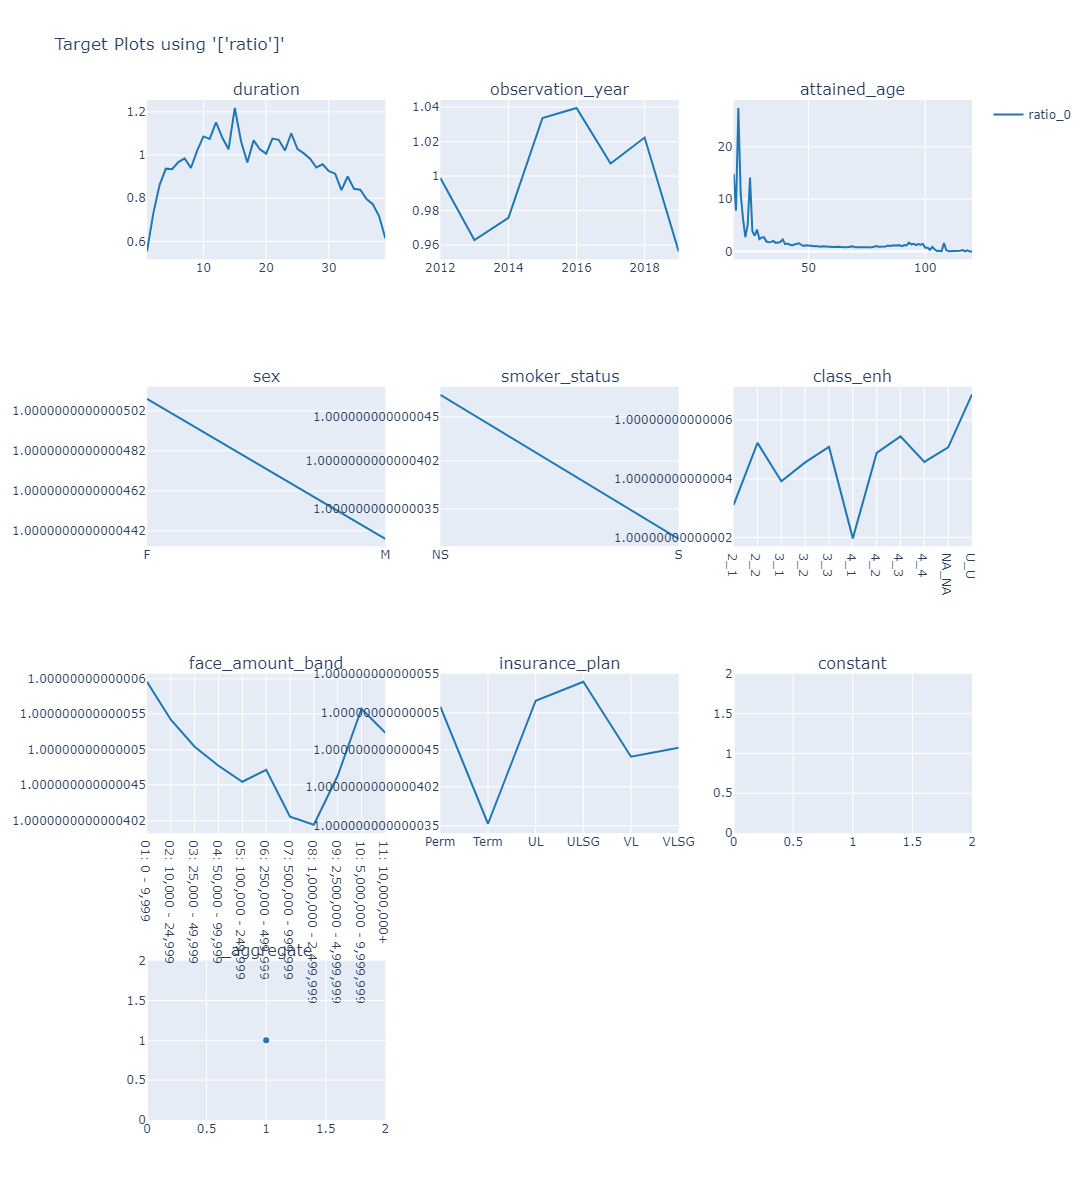

In [109]:
charters.target(
    df=model_data.loc[X.index],
    target="ratio",
    cols=3,
    features=model_features,
    numerator=["death_claim_amount"],
    denominator=["exp_amt_glm"],
).show()

# Credibility

 2024-06-11 22:31:34 | morai.experience.credibility | INFO     | Credibility calculated using 'limited fluctuation' on 'death_count'.
Dataframe does not need to be seriatim.
Created column 'credibility_lf'.
Full credibility threshold: 1,082.2
Probability measure within range: 0.9
Range +/-: 0.1
Standard deviation: 1.0
Mean: 1.0 


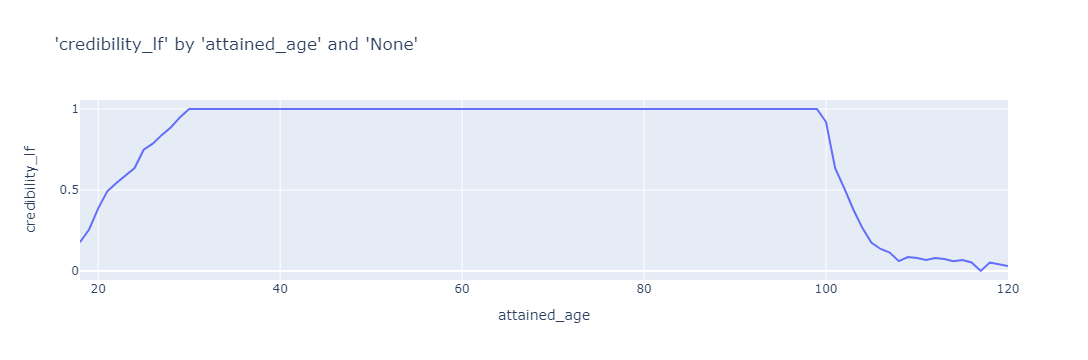

In [64]:
charters.chart(
    df=credibility.limited_fluctuation(
        df=grouped_df, measure="death_count", groupby_cols=["attained_age"]
    ),
    x_axis="attained_age",
    y_axis="credibility_lf",
    type="line",
)

 2024-06-11 22:31:21 | morai.experience.credibility | INFO     | Credibility calculated using 'asymptotic' on 'death_count'.
Dataframe does not need to be seriatim.
Created column 'credibility_as'.
Constant k: 270. 


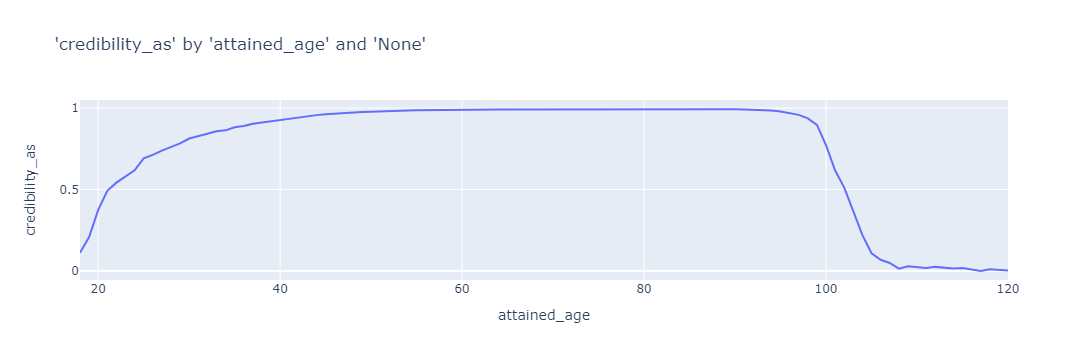

In [63]:
charters.chart(
    df=credibility.asymptotic(
        df=grouped_df, measure="death_count", groupby_cols=["attained_age"]
    ),
    x_axis="attained_age",
    y_axis="credibility_as",
    type="line",
)

 2024-06-11 22:30:26 | morai.experience.credibility | INFO     | Credibility calculated using 'SOA VM-20 approximation'.
Created column 'credibility_vm20_approx'.
Dataframe does not need to be seriatim.
 


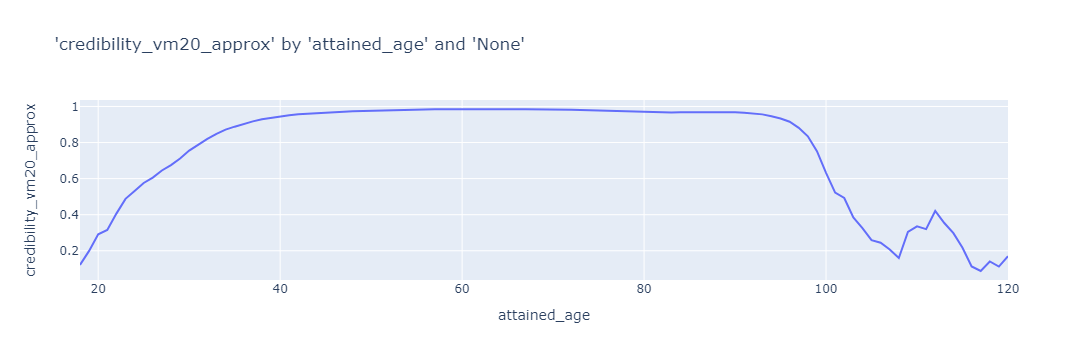

In [62]:
charters.chart(
    df=credibility.vm20_buhlmann_approx(
        df=grouped_df,
        a_col="exp_amt_vbt15",
        b_col="cen2momp1wmi_byamt",
        c_col="cen2momp2wmi_byamt",
        groupby_cols=["attained_age"],
    ),
    x_axis="attained_age",
    y_axis="credibility_vm20_approx",
    type="line",
)

# Reload

In [ ]:
importlib.reload(charters)

In [ ]:
importlib.reload(custom_logger)

In [ ]:
importlib.reload(forecasters)

In [ ]:
importlib.reload(helpers)

In [75]:
importlib.reload(preprocessors)

<module 'morai.forecast.preprocessors' from 'C:\\Users\\johnk\\Desktop\\github\\morai\\morai\\forecast\\preprocessors.py'>

In [ ]:
importlib.reload(credibility)

# Utilities

In [69]:
helpers.memory_usage_jupyter(globals=globals()).head(10)

,object,size_mb
0,grouped_df,171.30
1,corr,0.00
2,nan_counts,0.00
3,desc,0.00
4,columns_needed,0.00
5,columns_not_needed,0.00
6,variables,0.00
7,pl_parquet_path,0.00
8,open,0.00
9,measures,0.00
